## Example 4 - Matrix approaches - multiple paths

`Quagmire` allows the user to specify the number of downhill pathways to model flow in regions where diverging flow does not naturally fit the single-path-downhill view of the converging tributary view of stream flow. This also has some interesting effects on the numerical / discretisation errors.

```python
mesh.downhill_neighbours = 1
mesh.update_height(height)
```
where an integer specifies the number of downhill neighbour nodes (recipients) that will receive information of information from a donor node (1, 2 or 3 are usual, but the routine is general and will use second-nearest neighbours if they can be found at lower elevations). The `TopoMesh` object can also be initialised with:

```python
mesh = TopoMesh(DM, downhill_neighbours=1)
```

to specify the number of downhill neighbours (default is 2).

In this notebook we use a landscape function with many outflow points to examine the effect of varying the number of recipient nodes on catchment area, stream lengths, and outflow fluxes.

We also consider how expensive it is to use multiple path approaches.


#### Notebook contents

- [Meshing](#Build-a-test-mesh)
- [1-2-3 downhill neighbours](#1-2-3-downhill-neighbours)
- [Computational efficiency](#Computational-Efficiency)
- [Dense downhill matrices](#Dense-downhill-matrices)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## Build a test mesh

We use a circular, triangulated domain with a height that represents a _crenulated sombrero_ topography. No noise is added - any irregularities are the result of discretisation. 

In [2]:
from quagmire import FlatMesh 
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh


minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,

spacingX = 0.02
spacingY = 0.02

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY, random_scale=1.0)
DM = meshtools.create_DMPlex(x, y, simplices)

mesh = SurfaceProcessMesh(DM)

print( "\nNumber of points in the triangulation: {}".format(mesh.npoints))
print( "Downhill neighbour paths: {}".format(mesh.downhill_neighbours))

0 - Delaunay triangulation 0.1459060000000001s
0 - Calculate node weights and area 0.007687999999999917s
0 - Find boundaries 0.0018240000000000478s
0 - cKDTree 0.009615999999999847s
0 - Construct neighbour cloud array 0.3153070000000002s
0 - Construct rbf weights 0.06911999999999985s

Number of points in the triangulation: 62234
Downhill neighbour paths: 2


In [3]:
x = mesh.coords[:,0]
y = mesh.coords[:,1]
bmask = mesh.bmask

radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x) + 0.1

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(5.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)

with mesh.deform_topography():
    mesh.downhill_neighbours = 2
    mesh.topography.data = height

rainfall_fn = mesh.topography ** 2.0


0 - Build downhill matrices 0.17316899999999968s
0 - Build upstream areas 0.11275000000000013s



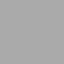

In [6]:
import lavavu

xyz_points = np.column_stack([mesh.tri.points, height])

lv = lavavu.Viewer(border=False, background="#FFFFEE", resolution=[800,600], near=-10.0)

nodes = lv.points("nodes", pointsize=1.0, colour="#444040", opacity=0.75)
nodes.vertices(xyz_points)

tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(xyz_points)
tris.indices(mesh.tri.simplices)
tris.values(mesh.topography.evaluate(mesh), label="height")
tris.values(rainfall_fn.evaluate(mesh), label="rainfall")

# tris.colourmap("#990000 #FFFFFF #000099")
tris.colourmap("elevation")
cb = tris.colourbar()

# view the pole

# lv.translation(0.0, 0.0, -3.0)
# lv.rotation(-20, 0.0, 0.0)

lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.Checkbox(property="wireframe")
tris.control.List(options=["height", "rainfall"], property="colourby", value="orginal", command="redraw", label="Display:")
lv.control.show()

In [7]:
mo1 = mesh.identify_outflow_points()
i = np.argsort(theta[mo1])
outflows = mo1[i]

## 1-2-3 downhill neighbours

In the case of 1 downhill neighbour, all of the water (information) from the parent node is given to a single recipient node. For more than one downhill neighbour, the water is partitioned based on the slope from the parent to recipient nodes.

From [Tucker *et al.* (2010)](http://doi.wiley.com/10.1002/esp.1952), the algorithm that controls this is:

$$
\frac{Q_i}{Q_{\mathrm{total}}} = \frac{S_i^{\alpha}}{\sum_{i=1}^{N} S_i^{\alpha}}
$$

where $\alpha = 0.5$.

In [8]:
flowpaths = mesh.upstream_integral_fn(rainfall_fn)

print("--- 2 downhill neighbours ---")
mesh.downhill_neighbours = 2
# mesh.update_height(height)

mo2 = mesh.identify_outflow_points()
flowpaths2 = flowpaths.evaluate(mesh)
outflow2   = flowpaths2[mo2]

# logpaths = np.log10(flowpaths)
# sqrtpaths = np.sqrt(flowpaths)

print("--- 3 downhill neighbour ---")
mesh.downhill_neighbours = 3
# mesh.update_height(height)

mo3 = mesh.identify_outflow_points()
flowpaths3 = flowpaths.evaluate(mesh)
outflow3   = flowpaths3[mo3]

# logpaths3 = np.log10(flowpaths3)
# sqrtpaths3 = np.sqrt(flowpaths3)

print("--- 1 downhill neighbour---")
mesh.downhill_neighbours = 1
# mesh.update_height(height)

mo1 = mesh.identify_outflow_points()
flowpaths1 = flowpaths.evaluate(mesh)
outflow1   = flowpaths1[mo1]


# logpaths1 = np.log10(flowpaths1)
# sqrtpaths1 = np.sqrt(flowpaths1)


--- 2 downhill neighbours ---
--- 3 downhill neighbour ---
--- 1 downhill neighbour---



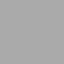

In [13]:
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[800,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=True)
tri1.vertices(xyz_points)
tri1.indices(mesh.tri.simplices)
tri1.values(flowpaths1, "stream power 1")
tri1.values(flowpaths2, "stream power 2")
tri1.values(flowpaths3, "stream_power 3")
tri1.colourmap("drywet")
tri1.colourbar()

lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(options=["stream power 1", "stream power 2", "stream_power 3"], property="colourby", value="stream power 1", command="redraw")
lv.control.show()

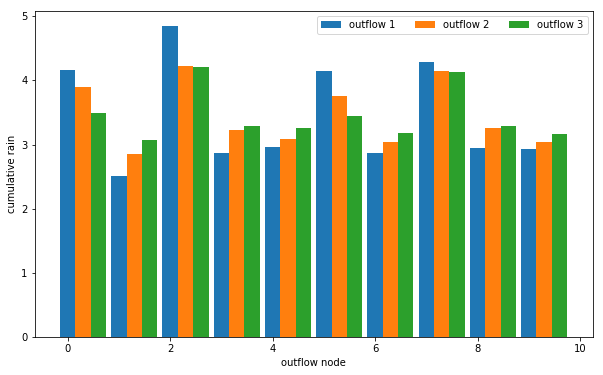

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


# plot bar graph of cumulative rain for each outflow point

outflow_range = np.arange(0, len(outflow1), dtype=np.float)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, xlabel='outflow node', ylabel='cumulative rain')
ax1.bar(outflow_range, width=0.3, height=outflow1, label='outflow 1')
ax1.bar(outflow_range+0.3, width=0.3, height=outflow2, label='outflow 2')
ax1.bar(outflow_range+0.6, width=0.3, height=outflow3, label='outflow 3')

ax1.legend(ncol=3)
plt.show()


## Computational Efficiency

Compare metrics of the downhill matrix...

The number of nonzero elements in the matrix increases with more downhill neighbours as does the construction time. The difference in solution converges after 3 downhill neighbours.

In [15]:
flowpaths_fn = mesh.upstream_integral_fn(rainfall_fn)
flowpaths = flowpaths_fn.evaluate(mesh)
# storage vectors
nz = []
max_diff = []


max_downhill_neighbours = 10

for n in range(2, max_downhill_neighbours):
    flowpaths_old = flowpaths.copy()
    
    mesh.downhill_neighbours = n
    # mesh.update_height(height)
    downhillMat_info = mesh.downhillMat.getInfo()
    
    flowpaths = flowpaths_fn.evaluate(mesh)
    # flowpaths = mesh.streamwise_smoothing(flowpaths, 2)
    
    nz.append( downhillMat_info['nz_allocated'] )
    max_diff.append( np.abs(flowpaths - flowpaths_old).max() )

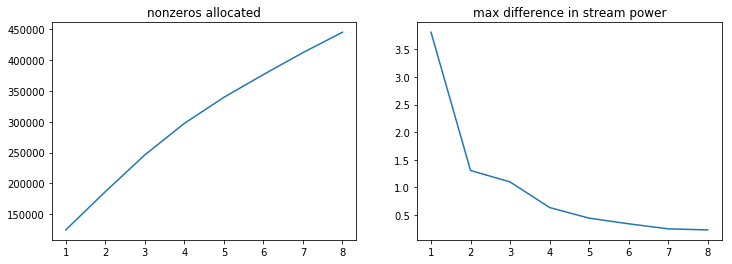

In [16]:
n_range = list(range(1, len(max_diff)+1))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(n_range, nz)
ax1.set_title('nonzeros allocated')
ax2.plot(n_range, max_diff)
ax2.set_title('max difference in stream power')
plt.show()

## Dense downhill matrices

The cumulative flow routine can (potentially) be sped up by multiplying the downhill matrix $\mathbf{D}$ by itself, which increases the number of nodes a parcel of information is moved to its downhill neighbours.

$$
\mathbf{D}_N = \mathbf{I} + \mathbf{D} + \mathbf{D}^2 + \mathbf{D}^3 + \ldots + \mathbf{D}^N
$$

where $N$ is the length of the graph. This can be repeated any number of times and is only limited by the available system memory ($N=3$ is already a very dense matrix). In this section we examine tradeoff between density of the matrix and cumulative flow iterations.

In [17]:
D1 = mesh.downhillMat
D2 = D1*D1
D4 = D2*D2
D8 = D4*D4

In [18]:

its = []
nz = []

rainfall = rainfall_fn.evaluate(mesh)

for i, downMat in enumerate([D1, D2, D4, D8]):
    downMatInfo = downMat.getInfo()
    
    mesh.downhillMat = downMat
    niter, flowpaths = mesh._cumulative_flow_verbose(mesh.area*rainfall)
    
    its.append(niter)
    nz.append(downMatInfo['nz_allocated'])
    

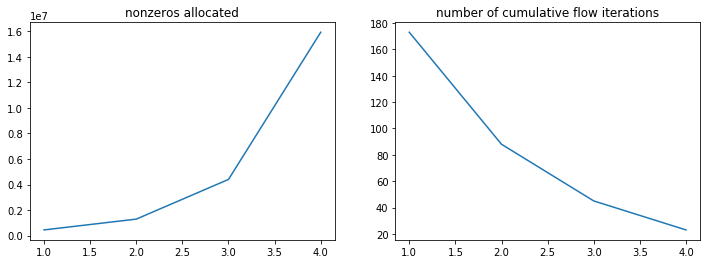

In [19]:
n_range = list(range(1, 5))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(n_range, nz)
ax1.set_title('nonzeros allocated')
ax2.plot(n_range, its)
ax2.set_title('number of cumulative flow iterations')
plt.show()

---

[Ex5-PreprocessingSurfaces](Ex5-PreprocessingSurfaces.ipynb)
